# How To HAMP 

This notebook provides a quick introduction on how to use the data collected by HAMP during the ORCESTRA campaign. The concept is that we do not produce processed datasets at this stage of the campaign, but do the postprocessing of the raw data on the fly. The processing functions are provided in the pyorcestra package and divided in level 1 and level 2 functions. Level 1 functions are mostly meant to fix the timeseries of the data and establish intuitive variable names. Level 2 functions filter the data and correct the radar altitude. 

We lead through the most basic workflow first and introduce a more sofisticated workflow relying on the ```PostProcessedHAMPData``` class at the end.

## 1. Low Complexity Workflow
### Import all necessary packages: 

In [23]:
import orcestra.postprocess.level0 as lev0
import orcestra.postprocess.level1 as lev1
import xarray as xr

### Load the raw data as xarray dataset and apply the level 0 processing:

In [24]:
# define flight
flight = "HALO-20240825a"

# Open data from dataserver
ds_bahamas = xr.open_dataset(
    f"/Volumes/ORCESTRA/{flight}/bahamas/QL_{flight}_BAHAMAS_V01.nc"
).pipe(lev0.bahamas)
ds_radio_183 = xr.open_dataset(
    f"/Volumes/ORCESTRA/{flight}/radiometer/183/{flight[7:-1]}.BRT.NC"
).pipe(lev0.radiometer)
ds_radio_kv = xr.open_dataset(
    f"/Volumes/ORCESTRA/{flight}/radiometer/kv/{flight[7:-1]}.BRT.NC"
).pipe(lev0.radiometer)
ds_radio_11990 = xr.open_dataset(
    f"/Volumes/ORCESTRA/{flight}/radiometer/11990/{flight[7:-1]}.BRT.NC"
).pipe(lev0.radiometer)
ds_iwv = xr.open_dataset(
    f"/Volumes/ORCESTRA/{flight}/radiometer/kv/{flight[7:-1]}.IWV.NC"
).pipe(lev0._fix_radiometer_time)
# Radardata should be copied to the local maschine since it is ~1.3 GB which would take long to load from server
ds_radar = (
    xr.open_mfdataset(
        f"/Users/jakobdeutloff/Programming/Orcestra/hamp_processing/Radar_Data/{flight}/*.nc"
    )
    .load()
    .pipe(lev0.radar)
)

### Apply level 1 processing. Data is filtered and the radar altitude is corrected:

In [19]:
ds_radio_183_lev1 = ds_radio_183.pipe(
    lev1.filter_radiometer, height=ds_bahamas["IRS_ALT"], roll=ds_bahamas["IRS_PHI"]
)
ds_radio_kv_lev1 = ds_radio_kv.pipe(
    lev1.filter_radiometer, height=ds_bahamas["IRS_ALT"], roll=ds_bahamas["IRS_PHI"]
)
ds_radio_11990_lev1 = ds_radio_11990.pipe(
    lev1.filter_radiometer, height=ds_bahamas["IRS_ALT"], roll=ds_bahamas["IRS_PHI"]
)
ds_iwv_lev1 = ds_iwv.pipe(
    lev1.filter_radiometer, height=ds_bahamas["IRS_ALT"], roll=ds_bahamas["IRS_PHI"]
)
ds_radar_lev1 = ds_radar.pipe(lev1.filter_radar, roll=ds_bahamas["IRS_PHI"]).pipe(
    lev1.correct_radar_height,
    altitude=ds_bahamas["IRS_ALT"],
    roll=ds_bahamas["IRS_PHI"],
    pitch=ds_bahamas["IRS_THE"],
)

### Done! Now you can use the postprocessed data :) 

## 2. High Complexity Workflow with more Features  
### Define a config file that holds all the information about where to find the data and where to put plots, data etc like the config_template.txt file

In [28]:
from src import plot_quicklooks as plotql
from src import load_data_functions as loadfuncs
from src import readwrite_functions as rwfuncs

# Read config file
configfile = "config.yaml"
cfg = rwfuncs.extract_config_params(configfile)
flightname = cfg["flightname"]
path_saveplts = cfg["path_saveplts"]

Reading config YAML: 'config.yaml'
No 'writedata' path found in config.yaml, path set to None
No 'hampdata' path found in config.yaml, path set to None


### Create PostProcessedHAMPData object which holds level1 data:

In [29]:
hampdata = loadfuncs.do_post_processing(
    cfg["path_bahamas"],
    cfg["path_radar"],
    cfg["path_radiometer"],
    cfg["radiometer_date"],
    is_planet=cfg["is_planet"],
    do_radar=True,
    do_183=True,
    do_11990=True,
    do_kv=True,
    do_cwv=True,
)

Using radar data from: /Users/jakobdeutloff/Programming/Orcestra/hamp_processing/Radar_Data/HALO-20240825a/*.nc
Using radiometer data from: /Volumes/ORCESTRA/HALO-20240825a/radiometer/183/240825.BRT.NC
Using radiometer data from: /Volumes/ORCESTRA/HALO-20240825a/radiometer/11990/240825.BRT.NC
Using radiometer data from: /Volumes/ORCESTRA/HALO-20240825a/radiometer/kv/240825.BRT.NC
Using column water vapour retrieval from: /Volumes/ORCESTRA/HALO-20240825a/radiometer/kv/240825.IWV.NC


### Now You can use predefined poltfunctions to generate quicklooks:

figure saved as .png in: /Users/jakobdeutloff/Programming/Orcestra/hamp_processing/quicklooks/HALO-20240825a/example.png


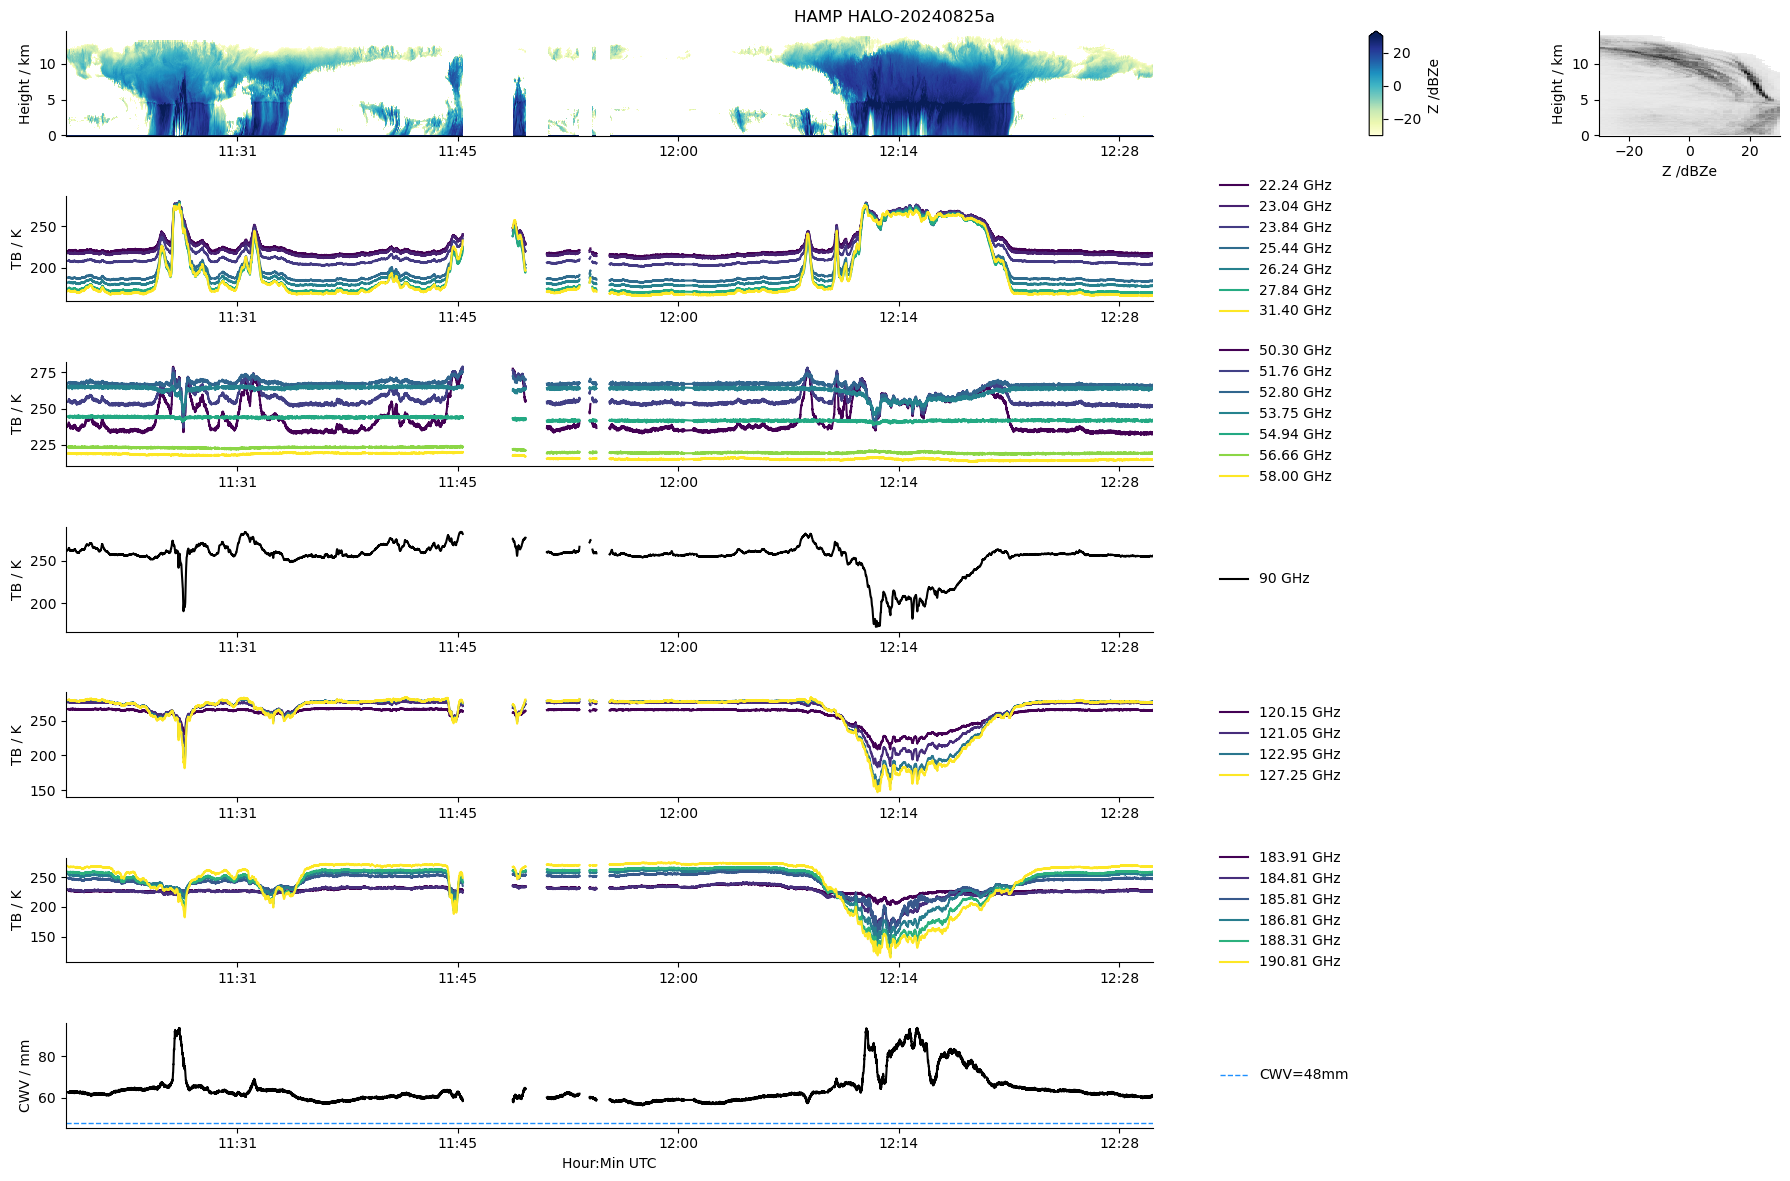

In [37]:
starttime, endtime = "2024-08-25 11:20", "2024-08-25 12:30"
timeframe = slice(starttime, endtime)
savefig_format = "png"
savename = path_saveplts / "example.png"
dpi = 70
fig, axes = plotql.hamp_timeslice_quicklook(
    hampdata,
    timeframe,
    flightname,
    ec_under_time=None,
    figsize=(18, 12),
    savefigparams=[savefig_format, savename, dpi],
)
fig.tight_layout()